In [1]:
from XRStools import xrs_read, xrs_extraction

 >>>>>>>>  use_PyMca  True
 >>>>>>>>  use_PyMca  True
/Users/katherinegraves/opt/miniconda3/envs/xrstools-test2/lib/python2.7/site-packages/PyMca5/PyMcaGui/plotting/MaskImageWidget.pyc
 Could not load PyTango
 >>>>>>>>  use_PyMca  True
                                                                                
 ############################# Welcome to XRStools #############################
 # If you are using this software, please cite the following work:             #
 # Ch.J. Sahle, A. Mirone, J. Niskanen, J. Inkinen, M. Krisch, and S. Huotari: #
 # "Planning, performing, and analyzing X-ray Raman scattering experiments."   #
 # Journal of Synchrotron Radiation 22, No. 2 (2015): 400-409.                 #
 ###############################################################################
                                                                                


In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [52]:
path = '/Users/katherinegraves/OneDrive - University of Leeds/PhD/Synchrotron/APS/Nov2019_NRIXS/XRSS/Luke_NIXS_2017/L_LA/'

In [53]:
myq = [2,5,8,9,10]

In [54]:
cnt = xrs_read.read_lerix(exp_dir=path,elastic_name='elastic',nixs_name='nixs',wide_name='wide')

>> >> Warning!! skipped empty scan (<7KB):  nixs.0034


In [151]:
file = '/Users/katherinegraves/OneDrive - University of Leeds/PhD/Synchrotron/APS/Nov2019_NRIXS/XRSS/Luke_NIXS_2017/L_LA/nixs.0034'

scan_info = cnt.scan_info(file)
qixs_list = []
scan_info

f = open(file, "r") #read starts here
text = f.read()
text = text.replace('\r\n', '\n').replace('\r', '\n').split('\n')
headers, dat, footers = cnt.separate_infile(text)

dat = [map(list,zip(*dat))[i][::-1] for i in range(len(dat[1]))] 
# this function does the inverse ([::-1]) transposition of the dat object, doesn't seem to work in windows

names = cnt.get_col_headers(cnt.strip_headers(headers)) 
#returns a list of names in the order found in the data file.

data = pd.DataFrame(np.array(dat).T,columns = np.array(names).T, dtype='float64') 
#returns a pandas array with the data arranged into labelled columns

In [152]:
# tests whether the energies are strictly increasing
# TRUE if strictly increasing, FALSE if not
np.all(np.diff(data.values[:,cnt.encolumn]) > 0)

True

In [50]:
# DELETE VALUES WHERE DATA IS NOT INCREASING
data = np.delete(data.values,np.where(np.diff(data.values[:,cnt.encolumn]) < 0),axis=0) 
# Energy values must be strictly increasing!

In [7]:
# load all elastics, nixs and wides in one go
cnt.load_elastics(analyzers='all')
cnt.load_nixs()
cnt.load_wides()

Reading elastic scan:  elastic.0001
Reading elastic scan:  elastic.0002
Reading elastic scan:  elastic.0003
Reading elastic scan:  elastic.0004
Running 'Update_Cenom' Script for All analysers
E0 was found to be (keV):  9.89062058079
Average FWHM for the elastics is (eV):  nan
Analyzer01 Elastic peak is less than 100 counts, setting to average e0
Analyzer04 Elastic peak is less than 100 counts, setting to average e0
Analyzer08 Elastic peak is less than 100 counts, setting to average e0
Analyzer10 Elastic peak is less than 100 counts, setting to average e0
Analyzer12 Elastic peak is less than 100 counts, setting to average e0
Analyzer13 Elastic peak is less than 100 counts, setting to average e0
Analyzer19 Elastic peak is less than 100 counts, setting to average e0
Reading NIXS scan:  nixs.0001
Reading NIXS scan:  nixs.0002
Reading NIXS scan:  nixs.0003
Reading NIXS scan:  nixs.0004
Reading NIXS scan:  nixs.0005
Reading NIXS scan:  nixs.0006
Reading NIXS scan:  nixs.0007
Reading NIXS sca

In [8]:
wide_signals  = np.array([cnt.scans[cnt.scan_info(i)[1]].signals for i in cnt.wide_scans]).mean(axis=0)
wide_eloss    = np.array([cnt.scans[cnt.scan_info(i)[1]].eloss for i in cnt.wide_scans]).mean(axis=0)
wide_energy = np.array([cnt.scans[cnt.scan_info(i)[1]].energy  for i in cnt.wide_scans]).mean(axis=0)
wide_errors = np.array([cnt.scans[cnt.scan_info(i)[1]].errors  for i in cnt.wide_scans]).mean(axis=0)

In [254]:
if not np.all(wide_eloss[1:] >= wide_eloss[:-1], axis=0) and np.all(cnt.eloss[1:] >= cnt.eloss[:-1], axis=0):
    print("Eloss in the wide and nixs scan/s must be strictly increasing! stopping.")

In [238]:
# idx is boolean with len=wide_eloss, True when in the range of nixs_eloss
idx = (wide_eloss>min(wide_eloss, key=lambda x:abs(x-min(cnt.eloss))))*(wide_eloss<=min(wide_eloss, key=lambda x:abs(x-max(cnt.eloss)))) 

# deletes wide_eloss values where False.
wide_eloss = np.delete(wide_eloss,np.where(idx)[0],axis=0)

# inserts nixs_eloss at the 0th value of idx
cnt.eloss = np.insert(wide_eloss,np.where(idx)[0][0],cnt.eloss,axis=0)  


In [239]:
cnt.eloss.shape # test shape of eloss axis (should be 505)

(506,)

In [240]:
# removes wide signal where there is nixs signal crossover
wide_signals_crossover = wide_signals[np.where(idx)[0][0]]
wide_signals = np.delete(wide_signals,np.where(idx)[0],axis=0)
wide_signals_crossover

array([1.89991038e-05, 5.34349785e-05, 1.03307623e-04, 1.78116595e-05,
       2.96860992e-05, 4.14417963e-04, 7.00591952e-05, 8.31210777e-05,
       8.37147997e-04, 2.01865480e-05, 3.38302779e-03, 1.06869957e-04,
       2.37488793e-04, 1.41305832e-03, 2.17539731e-03, 1.41899554e-03,
       1.93790852e-03, 1.07701164e-03, 3.44358762e-05])

In [193]:
# SCALING VARIABLES BELOW

In [241]:
# IF SCALING = 'AUTO'
# divides wide signal by nixs signal at crossover point
# creates array of scaling values for each analyser
scaling_test = np.divide(wide_signals_crossover,cnt.signals[0])
scaling_test.shape # 19 due to the number of analysers
scaling_test

array([1.7870934 , 1.05684033, 1.21371383, 0.76751315, 1.27439874,
       0.87005814, 1.08366683, 0.83280404, 1.00526576, 0.93929513,
       0.96004028, 0.94515093, 0.92356627, 1.02676395, 1.03023218,
       0.98221083, 0.91329683, 0.90903705, 1.07877822])

In [139]:
# # find analysers thet have zero for scaling_test
# idx_remove = np.where(scaling_test == 0)[0]
# idx_remove
# # delete scaling from analysers that have zero values
# scaling_test = np.delete(scaling_test,idx_remove)
# scaling_test
# # delete signals for analysers that have zero for scaling_test wide and nixs
# cnt.signals = np.delete(cnt.signals,idx_remove,axis=1)
# wide_signals = np.delete(wide_signals,idx_remove,axis=1)

array([4])

In [242]:
# TRY
# inserts the nixs scans to cut-out wide scans
test = np.insert(np.divide(wide_signals,scaling_test),np.where(idx)[0][0],cnt.signals,axis=0)
#test = np.insert(wide_signals,np.where(idx)[0][0],cnt.signals,axis=0)
test.shape

(506, 19)

<IPython.core.display.Javascript object>


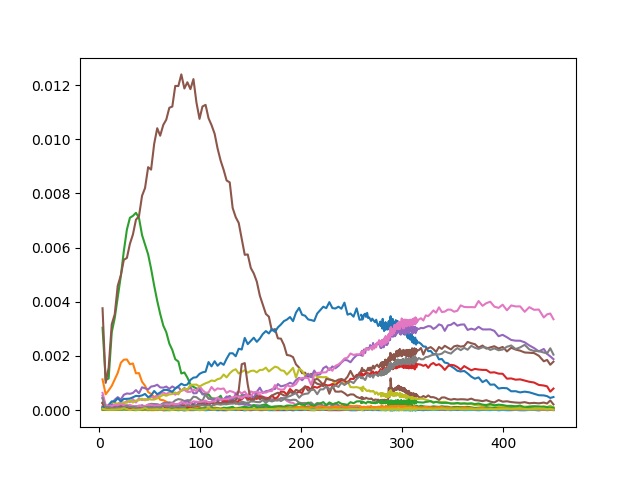

In [244]:
# plot
#plt.plot(cnt.eloss,test[:,2])
#plt.plot(cnt.eloss,test[:,5])
#plt.plot(cnt.eloss,test[:,8])
plt.plot(cnt.eloss,test)
plt.show()

<IPython.core.display.Javascript object>


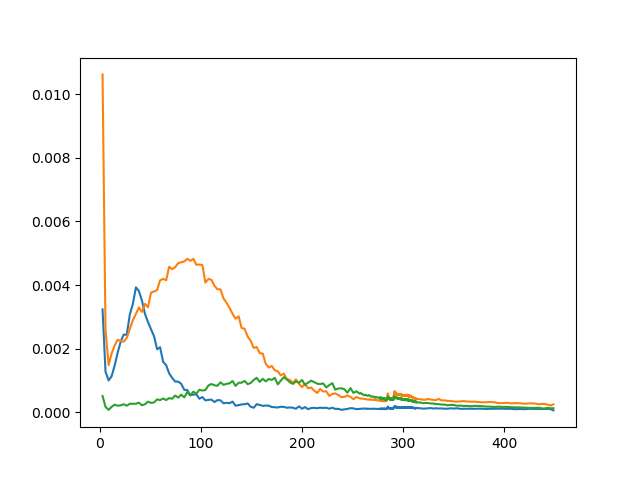

In [15]:
%matplotlib notebook
plt.plot(cnt.eloss,cnt.signals[:,[2,5,8]]) #interactive plot window to look at each analyser output
plt.show()

In [16]:
cnt.save_H5(H5name='PS_CNT_369_TAKE3')

ValueError: Unable to create group (name already exists)

In [ ]:
cnt.update_cenom(analyzers='all')

In [17]:
cnt_ex = xrs_extraction.edge_extraction(cnt,['C'],[1.0],{'C':['K']})

In [18]:
from XRStools import xrs_extraction

In [19]:
cnt_ex.analyzerAverage([2,5,8],errorweighing=False)

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


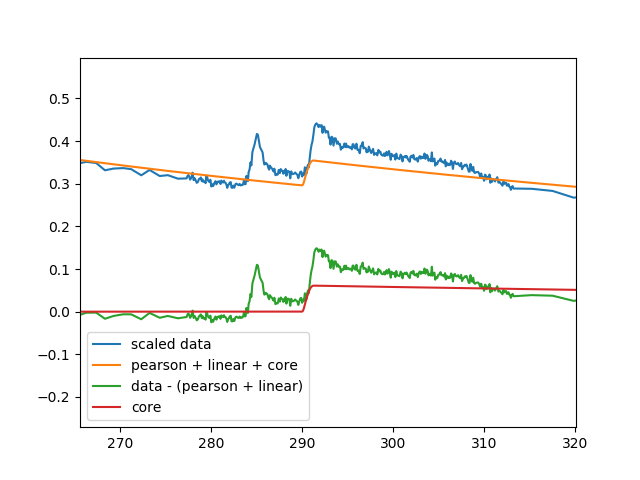

The fit parameters are:  [-7.10219927e+01  1.10523262e+02  1.58239157e+00  4.03676179e+01
  3.63420921e-05  2.91148181e-02  5.89410000e+00]


In [39]:
%matplotlib
cnt_ex.removeCorePearsonAv('C','K',[115,283.0],[330.0,450.0],weights=[2,1],HFcore_shift=5.6,scaling=5.9)

In [36]:
cnt_ex.save_average_Sqw(os.path.join(path,'PPCNT_data[369]_extract_BETTERSUBTRACT.dat'), emin=275,emax=340)

In [23]:
cnt_ex.sqwav

array([-7.77152158e-02, -1.67075856e+00, -1.88301166e+00, -1.82140068e+00,
       -1.70266202e+00, -1.63345653e+00, -1.58166419e+00, -1.51479837e+00,
       -1.48204356e+00, -1.34954199e+00, -1.27305350e+00, -1.19127270e+00,
       -1.12213330e+00, -1.09187320e+00, -1.01330387e+00, -1.00120305e+00,
       -9.35672081e-01, -9.09215604e-01, -8.43457706e-01, -8.27171839e-01,
       -7.87877498e-01, -7.73447825e-01, -7.10691412e-01, -6.74516420e-01,
       -6.51493383e-01, -5.88682498e-01, -5.47202835e-01, -5.06087598e-01,
       -4.64772268e-01, -4.42073893e-01, -4.12172159e-01, -4.01663127e-01,
       -3.67713715e-01, -3.84849219e-01, -3.38042139e-01, -3.25396885e-01,
       -3.03457834e-01, -2.84674233e-01, -2.79149063e-01, -2.61662446e-01,
       -2.35783842e-01, -2.20033970e-01, -2.27344761e-01, -2.19951276e-01,
       -2.06975362e-01, -2.04279147e-01, -2.27274074e-01, -1.83128734e-01,
       -1.64801973e-01, -1.75234752e-01, -1.34257258e-01, -1.54936892e-01,
       -1.49012273e-01, -